## Modules

In [1]:
import os
from pathlib import Path

# Import zipfile for zip file handling
import zipfile

# Import pytorch to build Models 
import torch
from torch.utils.data import DataLoader, random_split

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# import numpy for math calculations
import numpy as np

# Import skimage for image processing
from skimage.color import lab2rgb

# -------------Must Import-----------------
from dataset import ImageColorizationDataset

## .ZIP Extraction

Download the .zip file first: 
https://www.kaggle.com/datasets/shravankumar9892/image-colorization

In [2]:
extracted_folder = 'data'
if not os.path.exists(extracted_folder):
    with zipfile.ZipFile("archive.zip","r") as zip_ref:
        zip_ref.extractall(extracted_folder)

# List all the files in the extracted folder
os.listdir(extracted_folder)



['ab', 'l', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5']

## Data Preparation

In [5]:
ab_path = Path("data/ab/ab")
l_path = Path("data/l")

### Data Loader

In [6]:
batch_size = 32
# Prepare the Datasets
all_dataset = ImageColorizationDataset(l_dir=l_path, ab_dir=ab_path, reduced=True)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))


Tamaño del conjunto de entrenamiento: 2250
Tamaño del conjunto de validación: 450
Tamaño del conjunto de prueba: 300


### Data Visualization

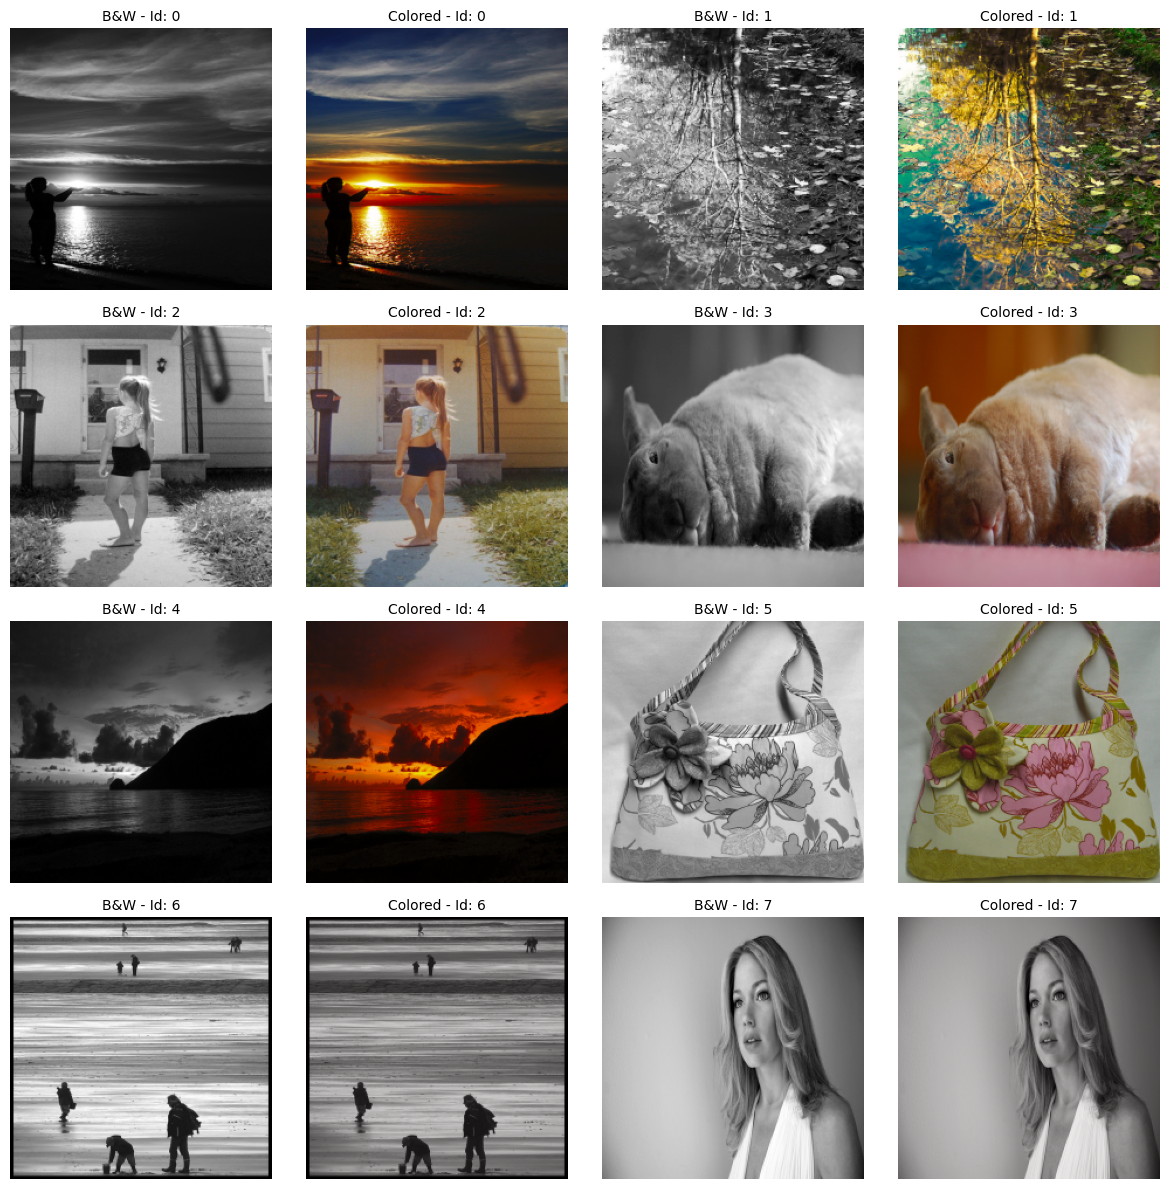

In [8]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Carga un batch del DataLoader

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()